In [1]:
import pickle
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit import execute

from matrix_qubo_source import *
from pipeline_QAOA import *

# Part 1: Defining the Puzzle and Reviewing the Solution

First we review the Star Battle puzzle, its formulation as a QUBO, and its corresponding solution. Instead of the 64 variable 8x8 puzzle we use a much simpler 4x4 puzzle with only 16 variables. The reason for this downscaling is due to the limitations of simulating systems of qubits on local hardware, as well as the physical limits of real quantum hardware. Even the most advanced gate model quantum computers have at most a few dozen qubits. As quantum computers continue to grow, the size of the puzzle in this example can grow with them, but the process of setting up and running QAOA (Quantum Approximate Optimization Algorithm) laid out in this notebook should be consistent.

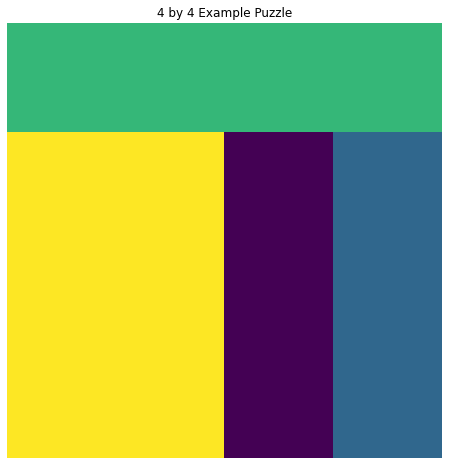

In [2]:
example_puzzle = 'AAAABBCDBBCDBBCD'
vals = {list(set(example_puzzle))[k]: k for k in range(len(set(example_puzzle)))}

plt.figure(figsize=(8,8))
plt.imshow(np.array([vals[char] for char in example_puzzle]).reshape((4,4)))
plt.axis('off')
plt.title('4 by 4 Example Puzzle')
plt.show()

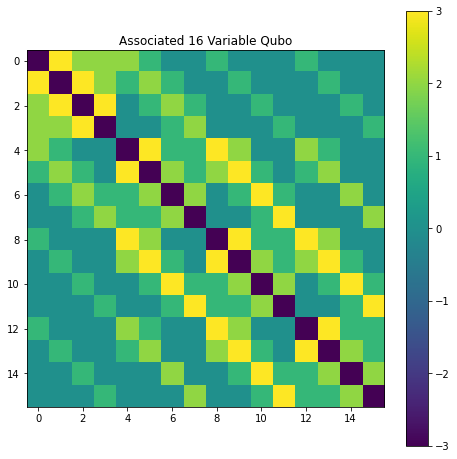

In [3]:
Q = make_qubo(example_puzzle)
plt.figure(figsize=(8,8))
plt.imshow(Q)
plt.title('Associated 16 Variable Qubo')
plt.colorbar()
plt.show()

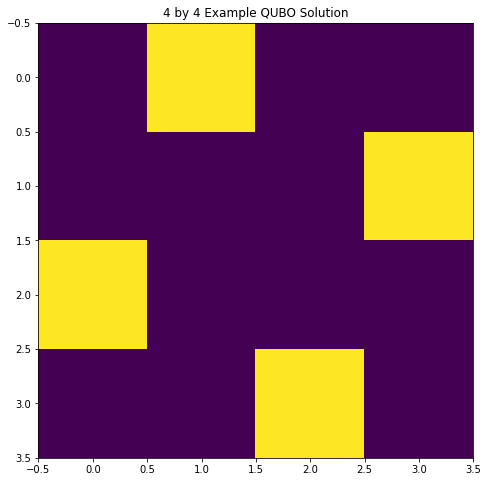

In [4]:
minimum, solution = get_results(Q, show=False)
plt.figure(figsize=(8,8))
plt.imshow(solution)
plt.title('4 by 4 Example QUBO Solution')
plt.show()

# Part 2: Converting from QUBO to Ising Model

The first step of getting a quantum answer to our problem is posing it correctly to the system that will solve it. In this case, we will be using IBM's Qiskit library, and the QAOA object from its Aqua component. See the associated video for more details, but the basic idea is that we will make a change of variables from $x \in \{0,1\}$ to $s \in \{1,-1\}$. Completing this transformation is achieved by a function in the pipeline_QAOA.py file. The image below displays the two outputs in one matrix. The linear terms are on the diagonal, and the quadratic terms form a strict upper triangular matrix.

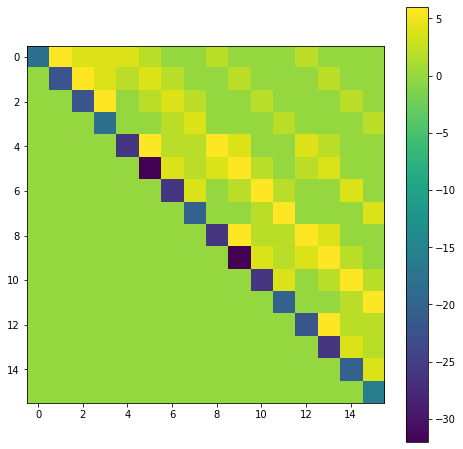

In [5]:
B, A = qubo_to_ising_model(Q)

to_visualize = B
for i in range(B.shape[0]):
    for j in range(B.shape[0]):
        if i==j:
            B[i,j] += A[i,0]
plt.figure(figsize=(8,8))
plt.imshow(to_visualize)
plt.colorbar()
plt.show()

The Ising model is a little different than the QUBO matrix from before. First, the QUBO matrix can hold its linear terms on the diagonal because $x^{2} = x, \forall x \in \{0,1\}$. This property called idempotence guarantees that the linear components in $x^{T}Qx$ will be captured exclusively on the diagonal entries of Q. This is not so for the ising spin variables $s \in \{1,-1\}$ so we formulate the expression to be minimized as $x^{T}Bx + A^{T}x$. See below that it achieves the same solution as the QUBO. Notably we have once again excluded the constant term in this formulation. This decision is the result of two reasons. First, it makes the conversion from our given QUBO much simpler. Second, it will not have an associated operator in the next step of the process, forming the Weighted Pauli Operator.

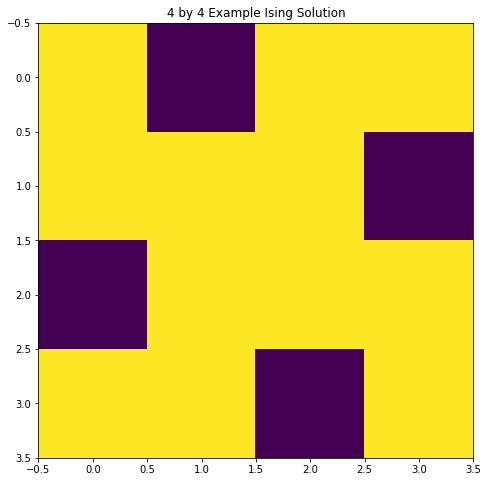

In [6]:
minimum, solution = get_results_ising(B, A, show=False)
plt.figure(figsize=(8,8))
plt.imshow(solution)
plt.title('4 by 4 Example Ising Solution')
plt.show()

# Part 3: Converting Ising Model into a Weighted Pauli Operator

Now that our QUBO has been successfully reformatted into an Ising model, we are ready to start using Qiskit's quantum library. Our matrix-vector pair directly corresponds to a series of single and double Z-gates which will form the cost Hamiltonian. In essence, the linear terms in A will be single-qubit Z gates weighted by said linear term, and the quadratic terms in B will be double-qubit Z gates weighted accordingly. Below we construct the WeightedPauliOperator object and display how Qiskit interprets one of the Paulis in the context of a quantum circuit. Notice that it is a tensor product of 14 identity operators and two Z gates.

In [7]:
WPO = ising_to_WPO(B, A)

In [8]:
circ = WPO.construct_evaluation_circuit(QuantumCircuit(16),statevector_mode=True)

In [9]:
print(circ[2])
print(str(len(circ))+' Paulis in WPO Object')

      ┌──────────────────────────┐
 q_0: ┤0                         ├
      │                          │
 q_1: ┤1                         ├
      │                          │
 q_2: ┤2                         ├
      │                          │
 q_3: ┤3                         ├
      │                          │
 q_4: ┤4                         ├
      │                          │
 q_5: ┤5                         ├
      │                          │
 q_6: ┤6                         ├
      │                          │
 q_7: ┤7                         ├
      │   Pauli IIIIIIIIIIIIIIZZ │
 q_8: ┤8                         ├
      │                          │
 q_9: ┤9                         ├
      │                          │
q_10: ┤10                        ├
      │                          │
q_11: ┤11                        ├
      │                          │
q_12: ┤12                        ├
      │                          │
q_13: ┤13                        ├
      │             

As a brief check, it is not a bad idea to find the energy associated with the true solution. Since QAOA is an approximation algorithm, we would hope that for a more precise approximation, the energies of the eigenstates the algorithm thinks are "good" solutions should approach the true value.

In [10]:
true_solution = '0100000110000010'
WPO.evaluate_with_statevector(np.array([int(i == int(true_solution,2)) for i in range(2**16)]))

((-186+0j), 0.0)

# Part 4: Running QAOA with Qiskit

Now we finally have our QUBO in a form that can be processed by Qiskit and fed into the QAOA algorithm. In the following cells, we initialize the object with the cost Hamiltonian, a classical optimizer called COBYLA, and a natural number p. In the next section, we will describe these parameters in more detail and analyze the results. One thing to note is that since the optimal parameters take a long time to generate from the classical optimizer, we have stored the results of running the algorithm with different p values in a pickle file, so that we can get these parameters without too much pain.

In [12]:
responses = pickle.load(open('QAOA_responses.pickle', 'rb'))

In [13]:
p_1 = QAOA(WPO, optimizer = COBYLA(), p=1)
p_2 = QAOA(WPO, optimizer = COBYLA(), p=2)
p_3 = QAOA(WPO, optimizer = COBYLA(), p=3)
p_4 = QAOA(WPO, optimizer = COBYLA(), p=4)
algs = [p_1, p_2, p_3, p_4]

Solution found at position 18327
Solution found at position 1
Solution found at position 67
Solution found at position 27


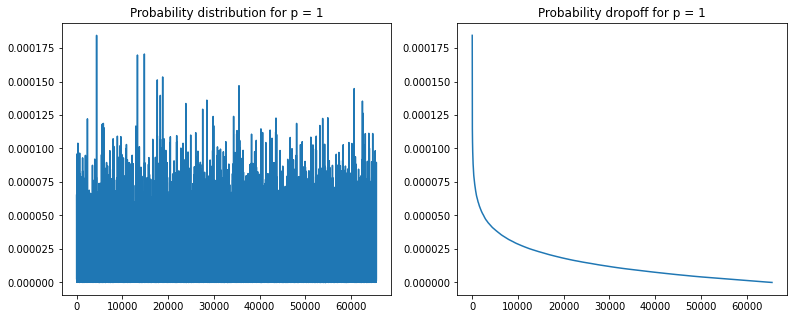

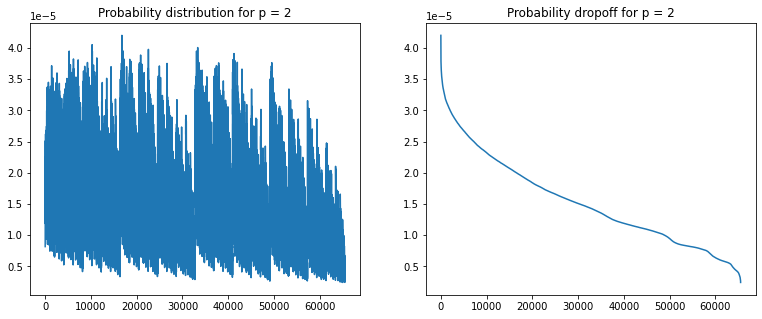

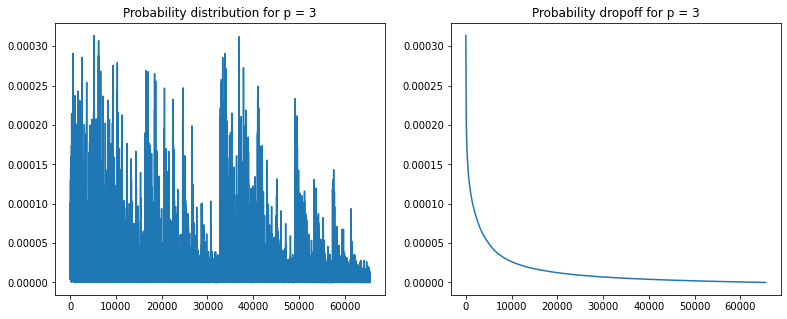

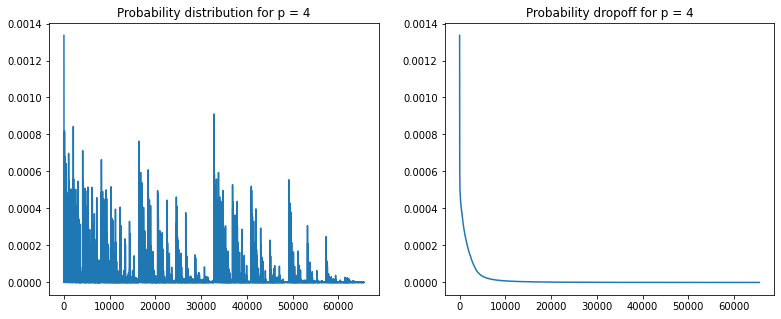

In [14]:
for i in range(4):
    p = i+1
    alg = algs[i]
    optimal_params = responses[i].optimal_point
    alg.backend = backend2
    circuit = alg.construct_circuit(optimal_params)
    simulation = execute(circuit, backend=backend1, shots=1000)
    sim_result = simulation.result()
    count = sim_result.get_counts()
    sorted_count = {state: val for state,val in sorted(count.items(), key=lambda item: item[1], reverse=True)}
    
    fig, ax = plt.subplots(1,2, figsize=(13,5))
    ax[0].set_title('Probability distribution for p = %d' % p)
    ax[0].plot(count.values())
    
    ax[1].set_title('Probability dropoff for p = %d' % p)
    ax[1].plot(sorted_count.values())
    #plt.xscale('log')
    
    counter = 1
    for key in sorted_count.keys():
        if true_solution == key:
            print('Solution found at position %d' % counter)
        counter+=1

In [15]:
times = []
energies = []
for response in responses[:4]:
    times.append(response.optimizer_time)
    energies.append(response.optimal_value)

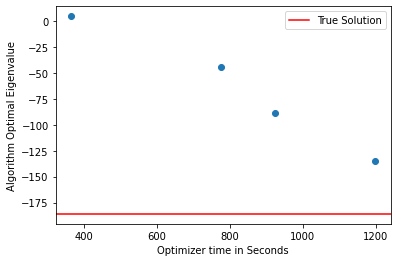

In [16]:
plt.scatter(times, energies)
plt.axhline(y=-186, color='r', label='True Solution')
plt.xlabel('Optimizer time in Seconds')
plt.ylabel('Algorithm Optimal Eigenvalue')
plt.legend()
plt.show()

# Part 5: Interpreting the Results

Now that we have seen the probability distributions of the algorithms for different p values using classically optimized parameters, we can talk more about what the algorithms is doing in higher level terms. We essentially fed a few things to the algorithm: a Hamiltonian, a classical optimizer, an integer p, and secretly a backend for simulating the process. First, the Hamiltonian represents the cost function associated with our original puzzle, and the eigenvector with the minimum eigenvalue should be the solution to our problem. The value of p linearly determines how many free parameters we have to optimize in this variational eigensolver. The optimizer is a classical tool that will attempt to optimize the free parameters in a 2p dimensional vector space. Lastly, the backend chosen simulates an IBM quantum processor running our algorithm.

The results seem to indicate that as p increases, the algorithm becomes more confident in the solutions it thinks are good, as indicated by the more defined structure in the distributions and the sharper dropoff in the elbow curves. In fact there appears to be some strange wizardry afoot in the p=2 case because not only is the distribution notably different than all the others, it manages to have the true solution as the most probable result, albeit by a very small margin. Unfortunately, since these are probability distributions and not true measurements, one would need to measure the circuit a large number of times to get a good sense of the distribution and conclude what the most probable result would be. Ideally, as p gets larger, the "good" solutions are boosted while the "bad" solutions are dampened. Theoretically, with infinite resources, we can scale p up as much as we want to get as close to the true solution as desired, but with time, memory for simulation, and real hardware limitations such upscaling is not currently feasible, so we end the discussion here.

# Part 6: Disclaimers

This analysis of QAOA is not to be conflated with an in-depth performance review of the algorithm or even a highly optimized coding example of using a quantum algorithm to solve a difficult problem. Even the problem in question is a scaled down version of a larger puzzle that can be iteratively solved with local hardware. Furthermore, due to lack of domain-specific knowledge about the COBYLA optimizer, the time contraints and validity of the so called "optimal" parameters produced cannot be interpreted to be authoritative. Lastly, results for p=5 and p=6 were too strange so they were not included in the discussion. What I truly hope you get from this notebook is that there is more to QAOA than solving MAXCUT on regular graphs and maybe an intuition of how to prepare your own Quadratic Unconstrained Binary Optimization problems on quantum computers as they become more powerful.